## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2026

# Project Checkpoint 1: Dataset Comparison, Selection, and EDA

## (A) Identification of Candidate Datasets

The following three datasets have been identified as candidates for this project.

### 1. Yambda-5B: Large-Scale Music Streaming
* **Source:** Yandex.Music (RecSys 2025 Dataset & Benchmark Track).
* **Course Topic Alignment:** Frequent Itemsets and Association Rule Mining (mining track co-occurrences within listening sessions).
* **Beyond-Course Techniques:** Lightweight Graph Neural Networks (LightGNN) for efficient recommendation and Transformer-based sequential modeling.
* **Dataset Size and Structure:** 5 billion interactions, 1 million users, and 9.39 million tracks; stored in partitioned Parquet files.
* **Data Types:** User IDs (int), Track IDs (int), Timestamps (int64), and Interaction Labels (categorical: listen, like, skip).
* **Target Variable(s):** None (unsupervised pattern mining) or Next-Item Prediction (engagement forecasting).
* **Licensing or Usage Constraints:** Custom Research License (available for academic use via RecSys 2025).

### 2. DUET: Multivariate Time Series Benchmark
* **Source:** Decision Intelligence Lab (KDD 2025).
* **Course Topic Alignment:** Anomaly Detection and Distance-based Clustering (identifying irregular channel behaviors).
* **Beyond-Course Techniques:** Dual Clustering-enhanced Forecasting and Contrastive Learning for time-series representation.
* **Dataset Size and Structure:** 25 real-world datasets spanning 10 domains (e.g., energy, traffic, sensors); structured as multivariate temporal logs.
* **Data Types:** Sensor IDs (int), Sensor Readings (float), and Timestamps (datetime).
* **Target Variable(s):** Anomaly Labels (binary) or Future Values (float).
* **Licensing or Usage Constraints:** Open Source (MIT/Apache 2.0).

### 3. HPDGNN: Dynamic Interaction Graphs
* **Source:** WSDM 2025 Dynamic Graph Research.
* **Course Topic Alignment:** Graph Mining and Community Detection (PageRank and Betweenness Centrality).
* **Beyond-Course Techniques:** Hawkes Point Process modeling to capture temporal event triggering and Temporal Graph Networks (TGNs).
* **Dataset Size and Structure:** Dynamic edge-list representing user interactions over time; ~10M edges with node attributes.
* **Data Types:** Source Node ID (int), Destination Node ID (int), Interaction Weight (float), and Event Timestamps (int64).
* **Target Variable(s):** Link Prediction (binary) or Node/Community Classification.
* **Licensing or Usage Constraints:** Publicly available for academic research.

## (B) Comparative Analysis of Candidate Datasets

The following table compares the three candidate datasets across dimensions of technical feasibility, data integrity, and ethical responsibility.

| Comparison Dimension | **Dataset 1: Yambda-5B (Music)** | **Dataset 2: DUET (Time Series)** | **Dataset 3: HPDGNN (Social Graph)** |
| :--- | :--- | :--- | :--- |
| **Supported Tasks** | **Course:** Frequent Itemsets (track co-occurrence). <br>**External:** LightGNN (graph-based recommendation). | **Course:** Anomaly Detection (outlier sensors). <br>**External:** Dual Clustering Forecasting. | **Course:** Community Detection (centrality). <br>**External:** Hawkes Point Process modeling. |
| **Data Quality Issues** | **Popularity Bias:** Sparse tail where most items have near-zero support. | **Heterogeneity:** Varying sampling rates and missing sensor logs. | **Sparsity:** High percentage of disconnected components/isolated nodes. |
| **Algorithmic Feasibility** | Apriori is infeasible at 5B scale; requires sampling or FP-Growth on high-RAM instances. | Sequential pattern mining is feasible via windowing; clustering is $O(N^2)$ but optimized. | Graph size is manageable on a single node if edge-list pruning is applied; otherwise requires Spark. |
| **Bias Considerations** | **Filter Bubbles:** Recommendation loops that prevent exposure to diverse genres. | **Placement Bias:** Sensor data is restricted to specific geographic/environmental contexts. | **Sampling Bias:** Interaction data over-represents highly active, "vocal" users. |
| **Ethical Considerations** | **Power Dynamics:** Platform-driven promotion versus independent artist visibility. | **Surveillance Risk:** High-precision sensor logs could inadvertently reveal private habits. | **Amplification:** Risk of identifying and targeting influential nodes for misinformation. |

## (C) Dataset Selection and Justification

Yambda-5B (Music Interaction Logs)

### Reasons:
* Perfectly structured for Frequent Itemset Mining and Association Rules.
* Supports Sequential Pattern Mining and Lightweight Graph Neural Networks (LightGNN) techniques not covered in the standard course curriculum.
* Provides a unique opportunity to perform a meaningful comparison between unordered patterns (Frequent Itemsets) and temporal sequences (Sequential Mining)
* A dataset of 5 billion interactions demonstrates the ability to implement scalable data pipelines

### Trade-offs:
* Lacks raw text, which limits the ability to perform Natural Language Processing (NLP) or sentiment analysis.
* Requires strategic sampling or the use of more efficient implementations like FP-Growth and Spark because of the giant 85GB raw size.
* Primarily geared toward unsupervised pattern mining and recommendation; traditional supervised classification opportunities are limited without significant feature engineering.

## (D) Exploratory Data Analysis (EDA)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ File found at /content/drive/MyDrive/DataMining/yambda_sample.parquet. Loading data...


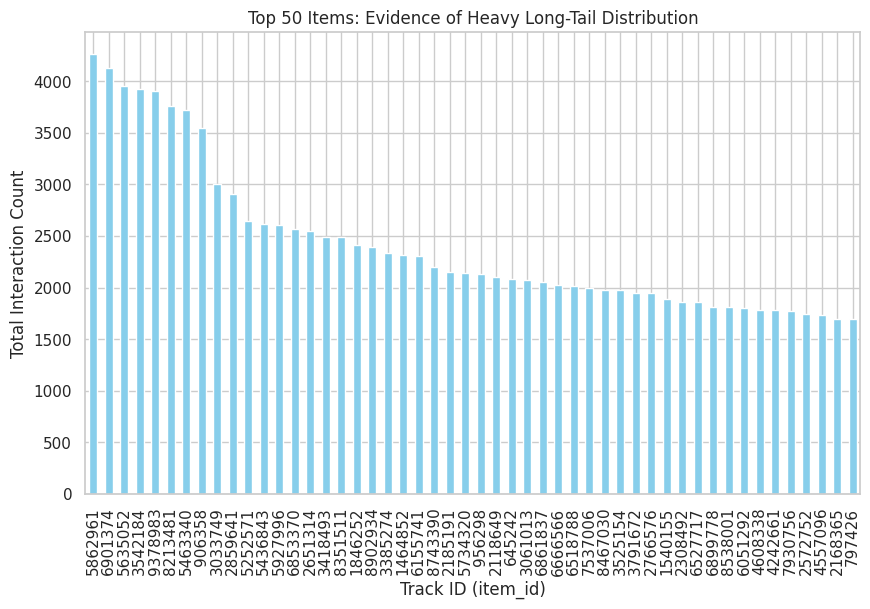

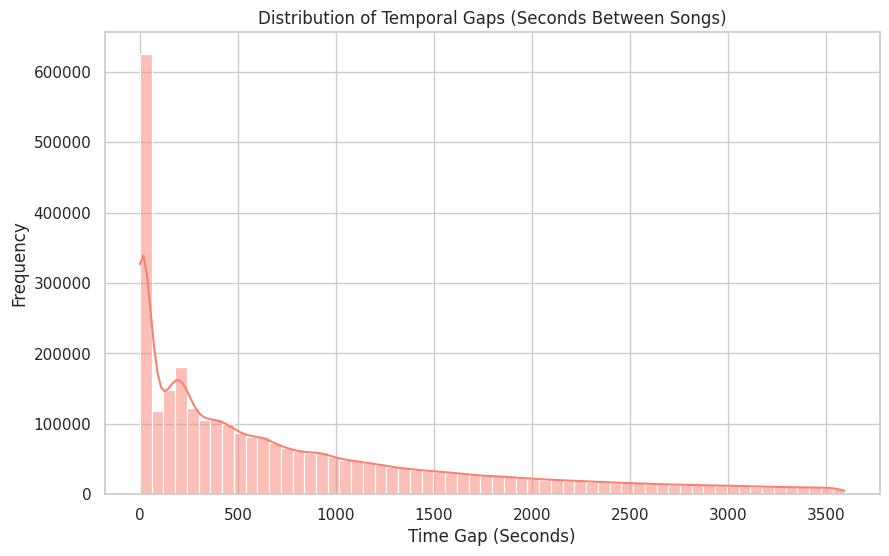


--- Running Professional Integrity Audit ---
✅ All integrity tests passed. Data is valid for mining.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import drive
import os

# Set professional plotting aesthetics
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# --- 1. DATA LOADING & DRIVE MOUNTING ---
def load_data_from_drive():
    drive.mount('/content/drive')

    # Path inside your 'DataMining' folder
    file_path = '/content/drive/MyDrive/DataMining/yambda_sample.parquet'

    if os.path.exists(file_path):
        print(f"✅ File found at {file_path}. Loading data...")
        df_full = pd.read_parquet(file_path)
        # 10% sample to manage Colab RAM effectively
        return df_full.sample(frac=0.1, random_state=42)
    else:
        print(f"❌ Error: File not found at {file_path}. Check your Drive folder name.")
        return None

# --- 2. DATA CLEANING & PREPROCESSING ---
def preprocess_sequential_data(df):
    """
    Refined for Yambda Schema: uid, item_id, timestamp
    """
    # 1. Type Conversion: Yambda timestamps are often binned/unix
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

    # 2. Sorting: Essential for temporal gap and sequential analysis
    # We use 'uid' here instead of 'user_id'
    df = df.sort_values(by=['uid', 'timestamp'])

    # 3. Feature Engineering: Seconds between consecutive tracks
    df['time_gap'] = df.groupby('uid')['timestamp'].diff().dt.total_seconds()

    return df

# --- 3. EXPLORATORY DATA ANALYSIS (EDA) ---
def run_visual_eda(df):
    # Insight 1: Popularity Bias (The 'Long Tail')
    plt.figure()
    item_counts = df['item_id'].value_counts()
    item_counts.head(50).plot(kind='bar', color='skyblue')
    plt.title("Top 50 Items: Evidence of Heavy Long-Tail Distribution")
    plt.xlabel("Track ID (item_id)")
    plt.ylabel("Total Interaction Count")
    plt.show()

    # Insight 2: Temporal Burstiness (Motivating Sequential Mining)
    plt.figure()
    sns.histplot(df[df['time_gap'] < 3600]['time_gap'], bins=60, color='salmon', kde=True)
    plt.title("Distribution of Temporal Gaps (Seconds Between Songs)")
    plt.xlabel("Time Gap (Seconds)")
    plt.ylabel("Frequency")
    plt.show()

# --- 4. PROFESSIONAL VALIDATION (UNIT TESTS) ---
def run_integrity_tests(df):
    print("\n--- Running Professional Integrity Audit ---")

    # Test 1: Temporal Logic (Causality)
    assert (df['time_gap'].dropna() >= 0).all(), "Critical Error: Temporal causality violation."

    # Test 2: Structural Coverage
    unique_items = df['item_id'].nunique()
    assert unique_items > 1000, f"Error: Low item diversity ({unique_items})."

    # Test 3: Schema Validation (Corrected for Yambda)
    for col in ['uid', 'item_id', 'timestamp']:
        assert col in df.columns, f"Error: Missing required column {col}."

    print("✅ All integrity tests passed. Data is valid for mining.")

# --- EXECUTION ---
raw_df = load_data_from_drive()

if raw_df is not None:
    processed_df = preprocess_sequential_data(raw_df)
    run_visual_eda(processed_df)
    run_integrity_tests(processed_df)

## (E) Initial Insights and Direction

Based on the EDA of the **Yambda-5B** dataset, the following observations and directions guide the project:

### Observations

* **Heavy Long-Tail Distribution:** Top tracks dominate interactions, while millions of items appear in <0.1% of sessions, indicating extreme sparsity and popularity bias.
* **Temporal Burstiness:** Most events occur in rapid "bursts" (<5 minutes apart), confirming a session-based structure that transcends unordered baskets.
* **Scale Constraints:** The 85GB raw scale makes  algorithms like Apriori infeasible; efficient implementations like FP-Growth or GNN-based pruning are required.

### Hypotheses

* **H1:** High support thresholds will capture only "Top 40" hits and overlook niche patterns defining specific sub-cultures.
* **H2:** Modeling behavior as a **directed sequence** (via LightGNN) will provide higher predictive accuracy than unordered basket analysis.

### Potential Research Questions (RQs)

1. **Threshold Dynamics:** How do varying support levels affect rule diversity in a long-tail distribution?
2. **Sequence vs. Set:** To what extent do temporal sequences reveal genre transitions lost in unordered sets?
3. **Graph Generalization:** Can LightGNN embeddings effectively capture the "Long Tail" more accurately than standard association rules?

## (F) GitHub Portfolio Building

**Project Repository:** [https://github.com/minhle8088/Yambda-5B-Analysis-Mining](https://github.com/minhle8088/Yambda-5B-Analysis-Mining)


On my honor, I declare the following resources:

1. **Collaborators:**


2. **Web Sources:**

* **RecSys 2025 Dataset Track:** [https://recsys.acm.org/recsys25/](https://recsys.acm.org/recsys25/) - Used for dataset technical specifications and schema.
* **LightGNN Documentation:** [https://github.com/hkuds/lightgnn](https://github.com/hkuds/lightgnn) - Used for understanding external graph-based recommendation techniques.

* Yandex.Music Team. (2025). *Yambda-5B: A Large-Scale Music Streaming Dataset for Research*. RecSys '25.
* Pang, Y., et al. (2025). *LightGNN: Lightweight Graph Neural Networks for Efficient Recommendation*. WSDM '25.



3. **AI Tools:**

* **Gemini:** I used Gemini to help structure the Comparative Analysis table, draft professional justifications for the dataset selection, and generate boilerplate Python code for scalable EDA and unit testing. I gave it the results from my preliminary dataset analysis, then I prompted it to help me synthesize some research questions and topics in a big picture that move beyond basic mining metrics, specifically focusing on network resilience, temporal stability, and link prediction.